In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import colorsys
from math import pi, ceil, floor, cos, sin
import glob
import pandas as pd

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

sys.path.insert(0, './segmentation_methods')

from ipynb.fs.full.general_functions import UNET_VALIDATION, HSV_VALIDATION, NO_VALIDATION
import ipynb.fs.full.methods_names as methods

_root       = "./blood_samples/samples/"
results_dir = "./segmented/"

2.4.1
2.4.0


Errors: 4


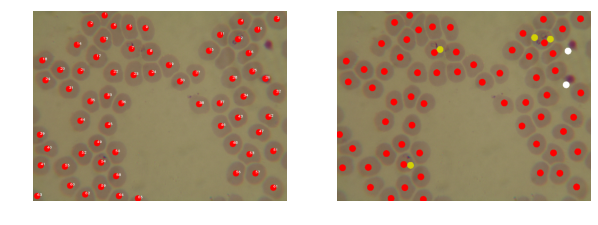

In [2]:
def not_yellow_random_color():
    color = np.random.randint(1,256, size=3)
    hsv = colorsys.rgb_to_hsv(color[0],color[1],color[2])
    if 30 <= hsv[0] <= 90:
        return not_yellow_random_color()
    return tuple((int(color[0]),int(color[1]),int(color[2])))
    

def compare_parasites_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
    
    manual = manual.copy()
    img = img.copy()
    
    #encontra as marcações relacionadas
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    for i in range(total_count1):
        if stats1[i, cv2.CC_STAT_AREA] > 1000:
            continue
        for y in range(total_count2):
            if stats2[y, cv2.CC_STAT_AREA] > 1000:
                continue
            
            dist = np.linalg.norm(centroids1[i]-centroids2[y])
            if dist < 30:
                color = not_yellow_random_color()
                cX, cY = centroids1[i]
                cv2.circle(img, (int(cX),int(cY)), 10, color, -1)
                cX, cY = centroids2[y]
                cv2.circle(manual, (int(cX),int(cY)), 10, color, -1)
                
                
    #conta quantas marcações amarelas sobraram
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    errors = 0
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    
#     plt.imshow(img_mask)
#     plt.show()
#     plt.imshow(manual_mask)
#     plt.show()
    errors = total_count1 + total_count2 - 2
    
    return errors, img, manual


if __name__ == "__main__":
    #manual = "./blood_samples/ground_truth/blood_smear_1.JPG"
    manual = "./blood_samples/ground_truth/blood_smear_7.JPG"
    manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img = "./segmented/hsv/blood_smear_1_otsu.png"
    img = "./segmented/oliveira/blood_smear_7.png"
    img    = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_parasites_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 79, 'true_negative': 0, 'false_positive': 8, 'false_negative': 19, 'cells_qtd': 87}
Errors: 27


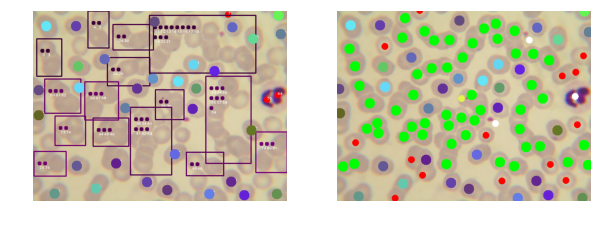

In [3]:


def get_img(name):
    return cv2.imread(name,1)
    
    
def not_red_random_color():
    color = np.random.randint(1,256, size=3)
    color[0] = 100
    if (color[1] < 100 and color[2] < 100):
        return not_red_random_color()
    elif (color[1] > 230 and color[2] > 230):
        return not_red_random_color()
    else:
        return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    manual = manual.copy()
    img = img.copy()
    
    
    true_positive = 0
    true_negative = 0 #nao sera usado
    false_positive = 0
    false_negative = 0
    
    errors = 0
    total = 0
    manual_total = 0
    max_area = 300#despreza as marcações das bordas
    min_area = 100
    
    #procura por todas as marcacoes que estejam em posicoes similares nas duas imagens
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_count, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total += total_count - 1
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_count, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_total += manual_count -1
    
    #print("total", total, "manual_total", manual_total)
    
    
    #das celulas restantes procuro a marcação relacionada
    for m_c in manual_centroids:
        i = 0
        for c in centroids:
            dist = np.linalg.norm(c-m_c)
            if dist < 20 and stats[i, cv2.CC_STAT_AREA] < max_area:
                cX, cY = m_c
                color = not_red_random_color()
                cv2.circle(manual, (int(cX),int(cY)), 13, color, -1)
                cX, cY = c
                cv2.circle(img, (int(cX),int(cY)), 13, color, -1)
                break
            i += 1
        
    
    #conta as células que estao agrupadas
    #relacionando com as posicoes na contagem manual
    
    
    def has_more_groups(img, color):
        mask = cv2.inRange(img, (color,0,color), (255,0,255))
        return np.sum(mask)

    color = 50

    
    while (has_more_groups(img, color)):
        #encontra a caixa        
        mask = cv2.inRange(img, (color+2,0,color+2), (color+2,0,color+2))
        
        #preenche as bordas falhadas do retangulo
        image = img_as_bool(mask)
        out = ndi.distance_transform_edt(~image)
        out = out < 0.05 * out.max()
        out = morphology.skeletonize(out)
        out = morphology.binary_dilation(out) #, morphology.footprints) #morphology.selem.disk(1)
        out = segmentation.clear_border(out)
        out = out | image
        mask[out] = 255
        
        #encontra o retangulo que envolve as celulas
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        sel = 0
        for c in range(len(cnts)):
            area = cv2.contourArea(cnts[c])
            if max_area < area:
                max_area = area
                sel = c
        x,y,w,h = cv2.boundingRect(cnts[sel])
        #cv2.rectangle(mask, (x,y), (x+w,y+h), 255, 3)
            
        
        #contagem das celulas encontradas pelo algoritmo
        #conta as celulas da cor da caixa
        mask_cells = cv2.inRange(img, (color,0,color), (color,0,color))
        box_count, _, _, _ = cv2.connectedComponentsWithStats(mask_cells, 4, cv2.CV_32S)
        #conta as celulas vermelhas ainda dentro da caixa
        img_cut = img[y:y+h,x:x+w]
        hsv = cv2.cvtColor(img_cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        
        cell_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                center = centroids[i]
                cell_count += 1
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(img, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        cell_count += box_count-1
        
        true_positive = cell_count
        
        
        #conta as celulas dentro da caixa na contagem manual
        cut = manual[y:y+h,x:x+w]
        hsv = cv2.cvtColor(cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        max_area = 300
        min_area = 100
        manual_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                manual_count += 1
                center = centroids[i]
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(manual, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        
        
        mask_cells = mask_cells[y:y+h,x:x+w]
        
        total        += cell_count
        manual_total += manual_count
        #print("count",cell_count, "manual",manual_count)
        
        err = cell_count - manual_count
        if (err > 0):
            false_positive += abs(err)
        else:
            false_negative += abs(err)
        errors += abs(err)
        
        color += 5

        
    #conta quantas marcacoes vermelhas sobraram em ambas
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_error, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total_error -= 1
    false_positive += total_error
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_error, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_error -= 1
    false_negative += manual_error
    
    errors += total_error + manual_error
    
    true_positive = total - false_positive
    
    return errors, img, manual, {"true_positive":true_positive, 
                                 "true_negative":true_negative,
                                 "false_positive":false_positive, 
                                 "false_negative":false_negative,
                                 "cells_qtd": total}


if __name__ == "__main__":
    #87 semar_8
    #95 manual
    #manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_7.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_8.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img    = cv2.cvtColor(cv2.imread("./segmented/oliveira/blood_smear_7.png",1), cv2.COLOR_BGR2RGB)
    img    = cv2.cvtColor(cv2.imread("./segmented/oliveira/blood_smear_8.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    
    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 80, 'true_negative': 0, 'false_positive': 15, 'false_negative': 17, 'cells_qtd': 95}
Errors: 32


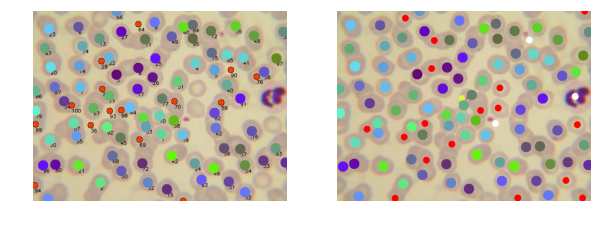

In [4]:
#87 semar_8
#95 manual
if __name__ == "__main__":

    manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_8.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./segmented/hsv/blood_smear_8_hough.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

In [5]:
def getManualCount(name):
    return {"method":"Manual", "path":name, "time":0}


def getOriginalCount(original_result_directory,name):
    name1 = name.replace(_root,original_result_directory+"/results/").replace(".jpg","_resultText.txt")
    image_name = name.replace(_root,original_result_directory+"/").replace(".jpg",".png")
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    
    return {"method"  :"Original",
            "time"    :float(data[4]),
            "path"    :image_name.replace("../","./")}

def getProjectCount(result_directory,validation,name,method):
    name = name.replace(_root,result_directory+"myresults/"+validation+"/").replace(".jpg","_result.txt")
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        
        data = lines[i].split("\t")
        if len(data) > 1:

            #se for para ler apenas um metodo especifico or ler os resultados de todos os metodos
            #metodos(de segmentacao)
            if method != None and data[0].strip() == method or method == None:
                ret.append({
                    'method'  : data[0].strip(),
                    'time'    : float(data[4].strip().replace("s","")),
                    'path'    : data[5].strip().replace("../","./")
                })
    return ret


def add_to_samples(samples,values):
    for key in values.keys():
        samples[key].append(values[key])
    
    if "validation_type" not in values.keys():
        samples['validation_type'].append(NO_VALIDATION)
    if "cells_error" not in values.keys():
        samples['cells_error'].append(-1)
    if "infection_error" not in values.keys():
        samples['infection_error'].append(-1)
    if ("true_positive" not in values.keys()):
        samples["true_positive"].append(-1)
        samples["true_negative"].append(-1)
        samples["false_positive"].append(-1)
        samples["false_negative"].append(-1)
        samples["acc"].append(-1)
        samples["precision"].append(-1)
        samples["recall"].append(-1)
        samples["f1-score"].append(-1)
    else:
        #(TP+TN)/(TP+TN+FP+FN)
        acc = (values["true_positive"]+values["true_negative"])/(values["true_positive"]+values["true_negative"]+values["false_positive"]+values["false_negative"])
        samples["acc"].append(acc)
        precision = values["true_positive"]/(values["true_positive"]+values["false_positive"])
        samples["precision"].append(precision)
        recall = values["true_positive"]/(values["true_positive"]+values["false_negative"])
        samples["recall"].append(recall)
        f1 = (2*precision*recall)/(precision+recall)
        samples["f1-score"].append(f1)
    
    
    
def read_result_data(results_dir,method=None):
    
    gt_directory = "./blood_samples/ground_truth/"

    samples = {"sample":[],
               "method":[],
               "time":[],
               "path":[],
               "validation_type":[],
               "infection_error":[],
               "cells_error":[],
               "true_positive":[],
               "true_negative":[], #nao usado
               "false_positive":[],
               "false_negative":[],
               "acc":[],
               "precision":[],
               "recall":[],
               "f1-score":[]}

    qtd = 0
    for file in glob.glob(gt_directory+"*.jpg"):
        qtd += 1
        
        #nome da amostra
        file = file.replace("\\","/").lower()
        name = file.replace("ground_truth","samples")
        sample_name = name.replace(gt_directory,"")
        samples['sample'].append(sample_name)

        #adiciona os dados do Ground truth a base
        manual = getManualCount(file)
        add_to_samples(samples,manual)
        
        
        for validation in [UNET_VALIDATION, HSV_VALIDATION, NO_VALIDATION]:

            #le os dados obtidos pelo projeto
            data = getProjectCount(results_dir, validation, name,  method)
            for dt in data:
                #adiciona na base
                samples['sample'].append(sample_name)
                #print("reading",dt['path'])
                dt['cells_error'], _, _, st = compare_markers(file, dt['path'])
                dt['infection_error'], _, _ = compare_parasites_markers(file, dt['path'])
                dt['validation_type']       = validation
                
                dt["true_positive"]  = st["true_positive"]
                dt["true_negative"]  = st["true_negative"]
                dt["false_positive"] = st["false_positive"]
                dt["false_negative"] = st["false_negative"]
            

                add_to_samples(samples,dt)

        
        #le os dados do projeto original
        orig = getOriginalCount("./segmented/oliveira", name)
        samples['sample'].append(sample_name)
        print("reading",orig['path'])
        orig['cells_error'], _, _, st = compare_markers(file, orig['path'])
        orig['infection_error'], _, _ = compare_parasites_markers(file, orig['path'])
        orig['validation_type']       = NO_VALIDATION
        
        orig["true_positive"]  = st["true_positive"]
        orig["true_negative"]  = st["true_negative"]
        orig["false_positive"] = st["false_positive"]
        orig["false_negative"] = st["false_negative"]
        
        #adiciona na base
        add_to_samples(samples,orig)

    try:
        samples = pd.DataFrame(data=samples)
    except:
        for key in samples:
            print (key," len:", len(samples[key]) )
    return samples

if __name__ == "__main__":
    samples = read_result_data(results_dir, method=None)
    print ("end")

reading ./segmented/oliveira/blood_smear_1.png
reading ./segmented/oliveira/blood_smear_11.png
reading ./segmented/oliveira/blood_smear_12.png
reading ./segmented/oliveira/blood_smear_13.png
reading ./segmented/oliveira/blood_smear_14.png
reading ./segmented/oliveira/blood_smear_15.png
reading ./segmented/oliveira/blood_smear_16.png
reading ./segmented/oliveira/blood_smear_17.png
reading ./segmented/oliveira/blood_smear_18.png
reading ./segmented/oliveira/blood_smear_19.png
reading ./segmented/oliveira/blood_smear_2.png
reading ./segmented/oliveira/blood_smear_20.png
reading ./segmented/oliveira/blood_smear_21.png
reading ./segmented/oliveira/blood_smear_22.png
reading ./segmented/oliveira/blood_smear_23.png
reading ./segmented/oliveira/blood_smear_24.png
reading ./segmented/oliveira/blood_smear_25.png
reading ./segmented/oliveira/blood_smear_26.png
reading ./segmented/oliveira/blood_smear_27.png
reading ./segmented/oliveira/blood_smear_28.png
reading ./segmented/oliveira/blood_smear_2

In [6]:
if __name__ == "__main__":
    samples

In [7]:
def print_accs(samples):
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('acc',ascending=False)
    print(smp[["validation_type","method","acc","precision","recall","f1-score"]].groupby(["method","validation_type"]).mean().round(3))

if __name__ == "__main__":
    print_accs(samples)




                                               acc  precision  recall  \
method                      validation_type                             
HSV                         hsv              0.684      0.958   0.704   
                            standalone       0.682      0.953   0.705   
                            unet             0.686      0.958   0.705   
HSV convex hull             hsv              0.676      0.940   0.708   
                            standalone       0.675      0.937   0.709   
                            unet             0.679      0.943   0.709   
Hough Circles               hsv              0.747      0.948   0.774   
                            standalone       0.758      0.936   0.794   
                            unet             0.764      0.944   0.794   
OTSU                        hsv              0.746      0.925   0.792   
                            standalone       0.741      0.909   0.803   
                            unet             0.750 